[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`.

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

In [2]:
import torch

input = torch.randn(64, 10, 20, 20)
# aumentamos la dimensión x2
conv_trans = torch.nn.ConvTranspose2d(
    in_channels=10,
    out_channels=10,
    kernel_size=2,
    stride=2)
output = conv_trans(input)
output.shape

torch.Size([64, 10, 40, 40])

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from pycocotools.coco import COCO
from PIL import Image, ImageOps
!ls

drive  sample_data


In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
coco_data=COCO("/content/drive/MyDrive/2-SIS421/2parcial/dataset/SEGMENTACION.v5i.coco-segmentation/valid/_annotations.coco.json")

loading annotations into memory...
Done (t=4.08s)
creating index...
index created!


In [10]:
img = coco_data.imgs[16]
print(len(coco_data.imgs))
img

304


{'id': 16,
 'license': 1,
 'file_name': 'ventana_393_jpg.rf.0e216c9d24e126ac6df50e27115f3040.jpg',
 'height': 394,
 'width': 394,
 'date_captured': '2023-11-07T18:42:36+00:00'}

uint8


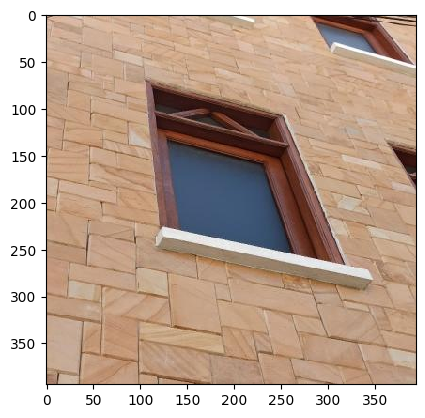

In [11]:
imagen = np.array(Image.open("/content/drive/MyDrive/2-SIS421/2parcial/dataset/SEGMENTACION.v5i.coco-segmentation/valid/"+img['file_name']))
print(imagen.dtype)
plt.imshow(imagen, interpolation='nearest')
plt.show()

[0, 1, 2, 3]
[16, 17]
[{'id': 16, 'image_id': 16, 'category_id': 3, 'bbox': [109, 75, 206.234, 190.459], 'area': 39279.19, 'segmentation': [[255.484, 116.584, 250.482, 109.273, 169.682, 87.727, 115.045, 74.645, 109.273, 75.029, 112.352, 129.666, 122.74, 226.242, 315.508, 265.104, 290.883, 199.693, 255.484, 116.584]], 'iscrowd': 0}, {'id': 17, 'image_id': 16, 'category_id': 3, 'bbox': [282, 0, 105.426, 51.559], 'area': 5435.605, 'segmentation': [[354.754, 9.619, 346.674, 6.926, 342.826, 1.539, 281.648, 0.385, 302.041, 34.629, 306.658, 30.012, 312.045, 30.781, 387.074, 51.943, 383.996, 44.248, 354.754, 9.619]], 'iscrowd': 0}]


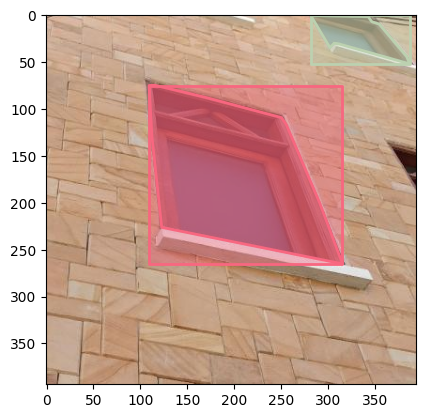

In [12]:
plt.imshow(imagen)
cat_ids = coco_data.getCatIds()
print(cat_ids)
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
print(anns_ids)
anns = coco_data.loadAnns(anns_ids)
print(anns)
coco_data.showAnns(anns,draw_bbox=True)

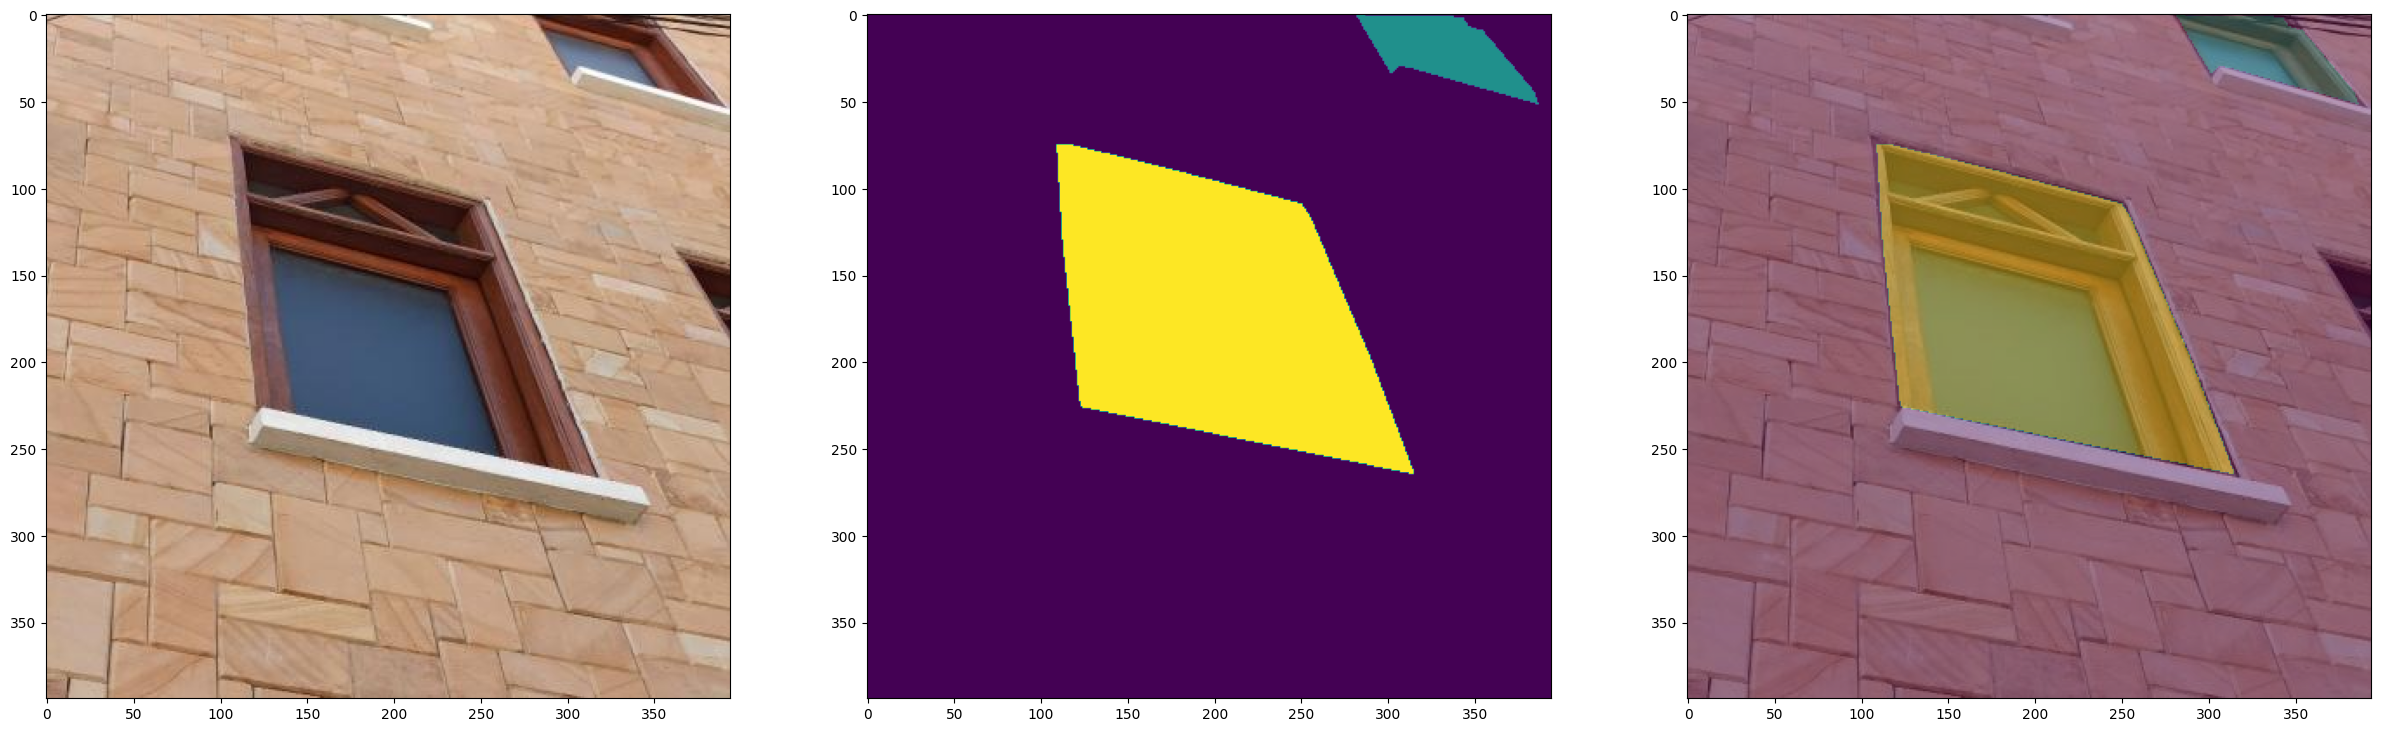

In [13]:
import matplotlib.pyplot as plt
import numpy as np

mask = coco_data.annToMask(anns[0])
#print(mask.shape)
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])
    #print(mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(imagen)
ax2.imshow(mask)
ax3.imshow(imagen)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [14]:
#Normalizar la imagen
imag = np.array(imagen)/255
image = imag.astype(np.float32)

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [18]:
image.shape, image.dtype, image.max(), image.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [19]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [20]:
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

## UNet

Vamos ahora a implementar nuestra red neuronal similar a `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [21]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [22]:
model = UNet()
output = model(torch.randn((1,3,640,640)))
output.shape

torch.Size([1, 3, 640, 640])

## Fit de 1 muestra

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida `BCEWithLogitsLoss`, que aplicará la función de activación `sigmoid` a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función `binary cross entropy`.

In [23]:


device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [24]:
img_tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 394, 394]), torch.Size([1, 3, 394, 394]))

In [25]:
fit(model, img_tensor, mask_tensor, epochs=30)

Epoch 1/30 loss 0.77091
Epoch 2/30 loss 0.74659
Epoch 3/30 loss 0.72621
Epoch 4/30 loss 0.70868
Epoch 5/30 loss 0.69339
Epoch 6/30 loss 0.67978
Epoch 7/30 loss 0.66731
Epoch 8/30 loss 0.65557
Epoch 9/30 loss 0.64434
Epoch 10/30 loss 0.63346
Epoch 11/30 loss 0.62276
Epoch 12/30 loss 0.61215
Epoch 13/30 loss 0.60156
Epoch 14/30 loss 0.59099
Epoch 15/30 loss 0.58048
Epoch 16/30 loss 0.57014
Epoch 17/30 loss 0.56014
Epoch 18/30 loss 0.55066
Epoch 19/30 loss 0.54177
Epoch 20/30 loss 0.53343
Epoch 21/30 loss 0.52541
Epoch 22/30 loss 0.51759
Epoch 23/30 loss 0.50996
Epoch 24/30 loss 0.50253
Epoch 25/30 loss 0.49526
Epoch 26/30 loss 0.48816
Epoch 27/30 loss 0.48124
Epoch 28/30 loss 0.47442
Epoch 29/30 loss 0.46770
Epoch 30/30 loss 0.46108


La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

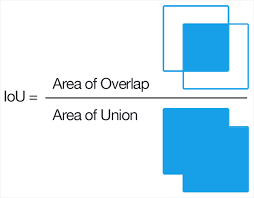

In [26]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [27]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [28]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.45452 iou 0.51284
Epoch 2/100 loss 0.43932 iou 0.51567
Epoch 3/100 loss 0.41859 iou 0.52866
Epoch 4/100 loss 0.39999 iou 0.50810
Epoch 5/100 loss 0.38223 iou 0.50067
Epoch 6/100 loss 0.36412 iou 0.49953
Epoch 7/100 loss 0.34652 iou 0.50448
Epoch 8/100 loss 0.32992 iou 0.50769
Epoch 9/100 loss 0.31455 iou 0.51059
Epoch 10/100 loss 0.29925 iou 0.53061
Epoch 11/100 loss 0.28527 iou 0.56921
Epoch 12/100 loss 0.27205 iou 0.64696
Epoch 13/100 loss 0.25936 iou 0.69298
Epoch 14/100 loss 0.24738 iou 0.67611
Epoch 15/100 loss 0.23600 iou 0.66193
Epoch 16/100 loss 0.22507 iou 0.62152
Epoch 17/100 loss 0.21456 iou 0.62165
Epoch 18/100 loss 0.20460 iou 0.60629
Epoch 19/100 loss 0.19529 iou 0.56090
Epoch 20/100 loss 0.18644 iou 0.55856
Epoch 21/100 loss 0.17775 iou 0.54378
Epoch 22/100 loss 0.16977 iou 0.52132
Epoch 23/100 loss 0.16230 iou 0.52123
Epoch 24/100 loss 0.15494 iou 0.52073
Epoch 25/100 loss 0.14805 iou 0.52520
Epoch 26/100 loss 0.14161 iou 0.52466
Epoch 27/100 loss 0.1

Ahora podemos generar predicciones para obtener máscaras de segmentación

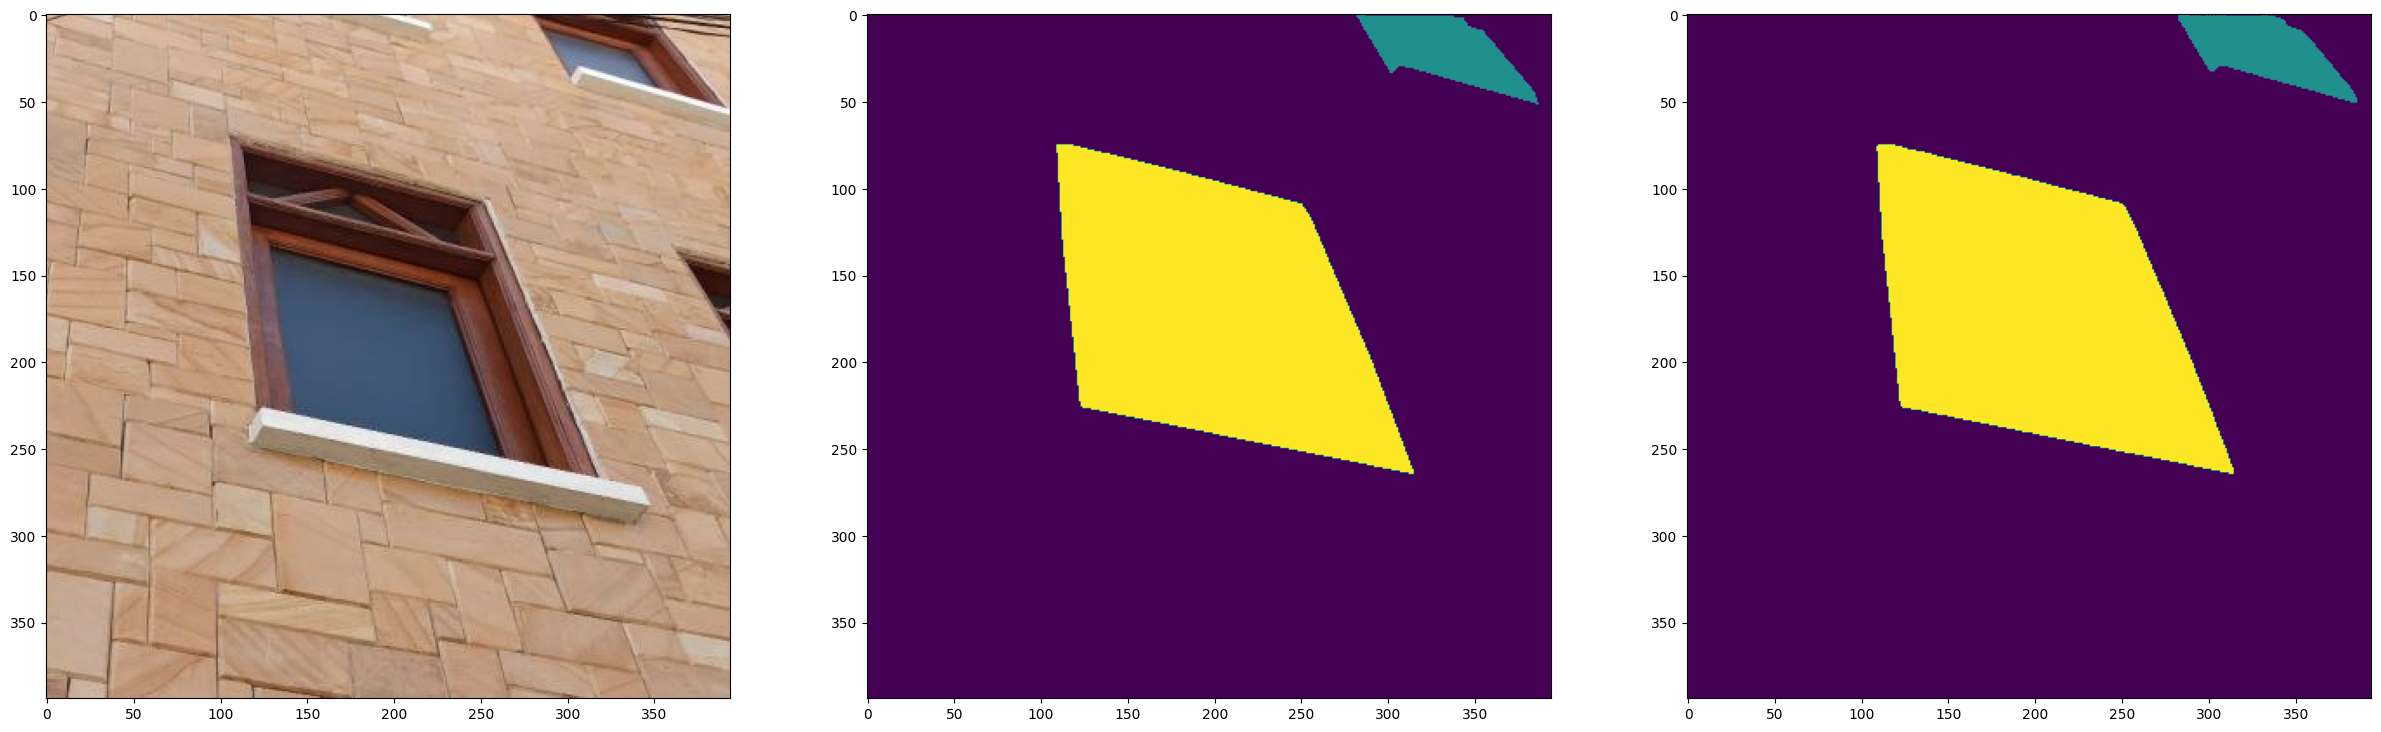

In [29]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [32]:
img = coco_data.imgs[16]
print(len(coco_data.imgs))
img

304


{'id': 16,
 'license': 1,
 'file_name': 'ventana_393_jpg.rf.0e216c9d24e126ac6df50e27115f3040.jpg',
 'height': 394,
 'width': 394,
 'date_captured': '2023-11-07T18:42:36+00:00'}

[0, 1, 2, 3]
[16, 17]
[{'id': 16, 'image_id': 16, 'category_id': 3, 'bbox': [109, 75, 206.234, 190.459], 'area': 39279.19, 'segmentation': [[255.484, 116.584, 250.482, 109.273, 169.682, 87.727, 115.045, 74.645, 109.273, 75.029, 112.352, 129.666, 122.74, 226.242, 315.508, 265.104, 290.883, 199.693, 255.484, 116.584]], 'iscrowd': 0}, {'id': 17, 'image_id': 16, 'category_id': 3, 'bbox': [282, 0, 105.426, 51.559], 'area': 5435.605, 'segmentation': [[354.754, 9.619, 346.674, 6.926, 342.826, 1.539, 281.648, 0.385, 302.041, 34.629, 306.658, 30.012, 312.045, 30.781, 387.074, 51.943, 383.996, 44.248, 354.754, 9.619]], 'iscrowd': 0}]


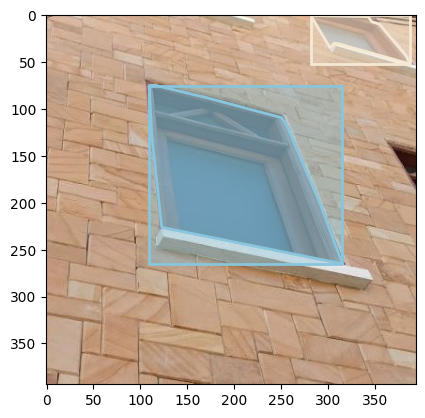

In [33]:

plt.imshow(imagen)
cat_ids = coco_data.getCatIds()
print(cat_ids)
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
print(anns_ids)
anns = coco_data.loadAnns(anns_ids)
print(anns)
coco_data.showAnns(anns,draw_bbox=True)

In [50]:
from random import sample
import numpy as np
from PIL import Image

def loadImages(dataset_coco, split=0.2):
    img_test_ = []
    img_train_ = []
    mask_test_ = []
    mask_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    data = dataset_coco.imgs
    print(len(data))
    test_ids = sample(list(data.keys()), int(len(data) * split))
    #print("test",test_ids)
    for i in data:
        image_id_ = data[i]['id']
        #print("a",image_id_)
        category = data_[i]['category_id']
        #print("b",category)
        img_ = dataset_coco.imgs[i]
        #print("c",img_)
        image_path = "/content/drive/MyDrive/2-SIS421/2parcial/dataset/SEGMENTACION.v5i.coco-segmentation/valid/" + img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_) / 255
        #print(image)
        cat_ids = coco_data.getCatIds()
        #print(cat_ids)
        anns_ids = coco_data.getAnnIds(imgIds=img_['id'], catIds=cat_ids, iscrowd=None)
        #print(anns_ids)
        anns_ = coco_data.loadAnns(anns_ids)
        #print("d",anns_, len(anns_))
        masks_ = []
        for ann in anns_:
            mask = dataset_coco.annToMask(ann)
            masks_.append(mask)
            #print("las masks",masks_)
        mask_ = np.sum(masks_, axis=0)
        #print(mask_)
        if i not in test_ids:
            img_train_.append(image_path)
            mask_train_.append(mask_)
            labels_train_.append(category)
        else:
            img_test_.append(image_path)
            mask_test_.append(mask_)
            labels_test_.append(category)
    return np.array(img_train_), np.array(img_test_), np.array(mask_train_), np.array(mask_test_), np.array(labels_train_), np.array(labels_test_)


In [51]:
img_train, img_test, mask_train, mask_test, labels_train ,labels_test = loadImages(coco_data, split=0.2)

304


In [52]:
img_train[0], img_test[0], mask_train[0].shape, mask_test[0].shape, labels_train[0].shape ,labels_test[0].shape

('/content/drive/MyDrive/2-SIS421/2parcial/dataset/SEGMENTACION.v5i.coco-segmentation/valid/platos_363_jpg.rf.0028fdeb5364d58270b95a8f072a019d.jpg',
 '/content/drive/MyDrive/2-SIS421/2parcial/dataset/SEGMENTACION.v5i.coco-segmentation/valid/platos_398_jpg.rf.01cf93a819c9e44d1873a6b932644ec7.jpg',
 (394, 394),
 (394, 394),
 (),
 ())

uint8
(394, 394)


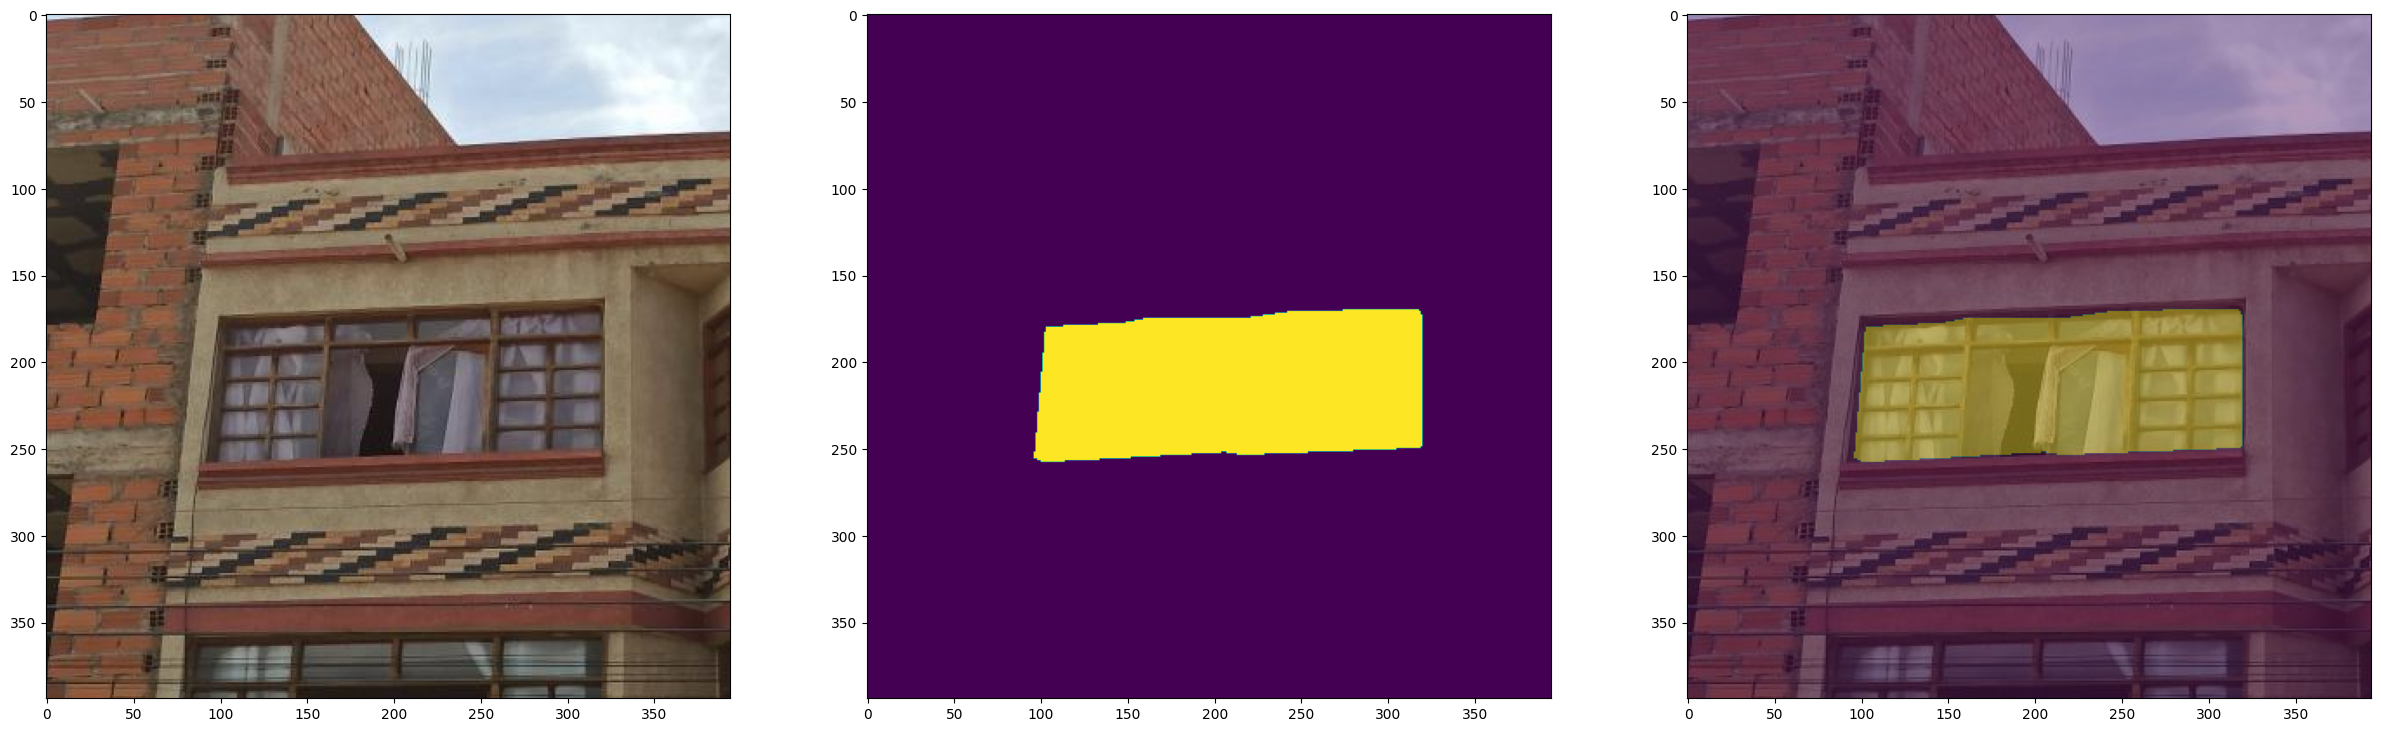

In [53]:
import matplotlib.pyplot as plt
import numpy as np
imagen = np.array(Image.open(img_test[45]))
print(imagen.dtype)
#img = imagen.astype(np.float32)
#print(imagen)
mask = mask_test[45]
print(mask.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(imagen)
ax2.imshow(mask)
ax3.imshow(imagen)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [54]:
import albumentations as A
from skimage import io
from skimage import color
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3, transform=None):
        self.X = X
        self.y = y
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        #image_load = Image.open(self.X[ix]).convert('RGB')
        img = io.imread(self.X[ix])
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
        image = np.array(img) / 255
        img = image.astype(np.float32)

        mask = self.y[ix]
        img = torch.from_numpy(img).permute(2, 0, 1)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)


        mask =torch.from_numpy(mask).permute(2, 0, 1)

        return img, mask

In [55]:
dataset = {
    'train': Dataset(img_train, mask_train),
    'test': Dataset(img_test, mask_train)
}

len(dataset['train']), len(dataset['test'])

(244, 60)

In [56]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=16, pin_memory=True)
}
imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 394, 394]), torch.Size([16, 3, 394, 394]))

## Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [57]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [58]:
model = UNet()
hist = fit(model, dataloader, epochs=3)

test_loss 0.64678 test_iou 0.18983: 100%|██████████| 4/4 [00:33<00:00,  8.36s/it]



Epoch 1/3 loss 0.61200 iou 0.33222 test_loss 0.64678 test_iou 0.18983


loss 0.53933 iou 0.38769:  31%|███▏      | 5/16 [02:31<05:32, 30.27s/it]


KeyboardInterrupt: ignored

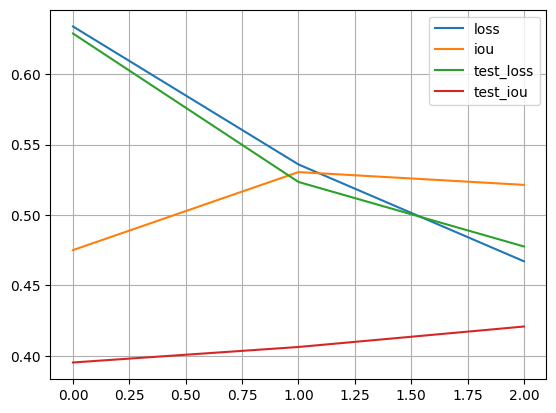

In [47]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

Podemos mejorar nuestros resultados si en vez de entrenar nuestra `UNet` desde cero utilizamos una red ya entrenada gracias al `transfer learning`. Para ello usaremos `ResNet` como `backbone` en el `encoder` de la siguiente manera.

In [48]:
import torchvision

In [49]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [52]:
model = UNetResnet()
output = model(torch.randn((10,3,394,394)))
output.shape

<ipython-input-51-a5faa7596774>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


torch.Size([10, 3, 394, 394])

In [53]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=3)

  0%|          | 0/17 [00:00<?, ?it/s]<ipython-input-51-a5faa7596774>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.90172 test_iou 0.14348: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]



Epoch 1/3 loss 0.68217 iou 0.36117 test_loss 0.90172 test_iou 0.14348


test_loss 0.84352 test_iou 0.49582: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]



Epoch 2/3 loss 0.51956 iou 0.72759 test_loss 0.84352 test_iou 0.49582


test_loss 0.59395 test_iou 0.55728: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


Epoch 3/3 loss 0.44112 iou 0.82656 test_loss 0.59395 test_iou 0.55728


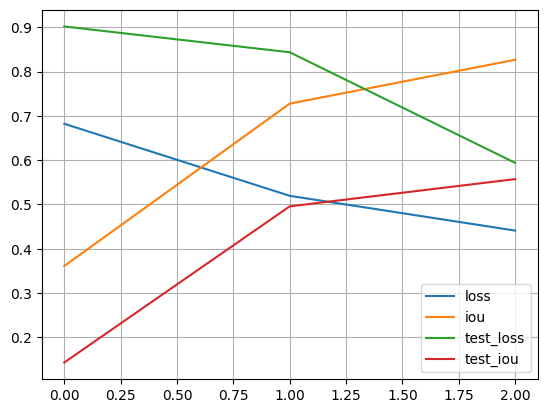

In [54]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

En este caso observamos como la red converge más rápido, sin embargo no obtenemos una gran mejora de prestaciones ya que nuestro dataset es muy pequeño y la naturaleza de las imágenes es muy distinta a las utilizadas para entrenar `ResNet`. Podemos generar máscaras para imágenes del dataset de test de la siguiente manera.

<ipython-input-51-a5faa7596774>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


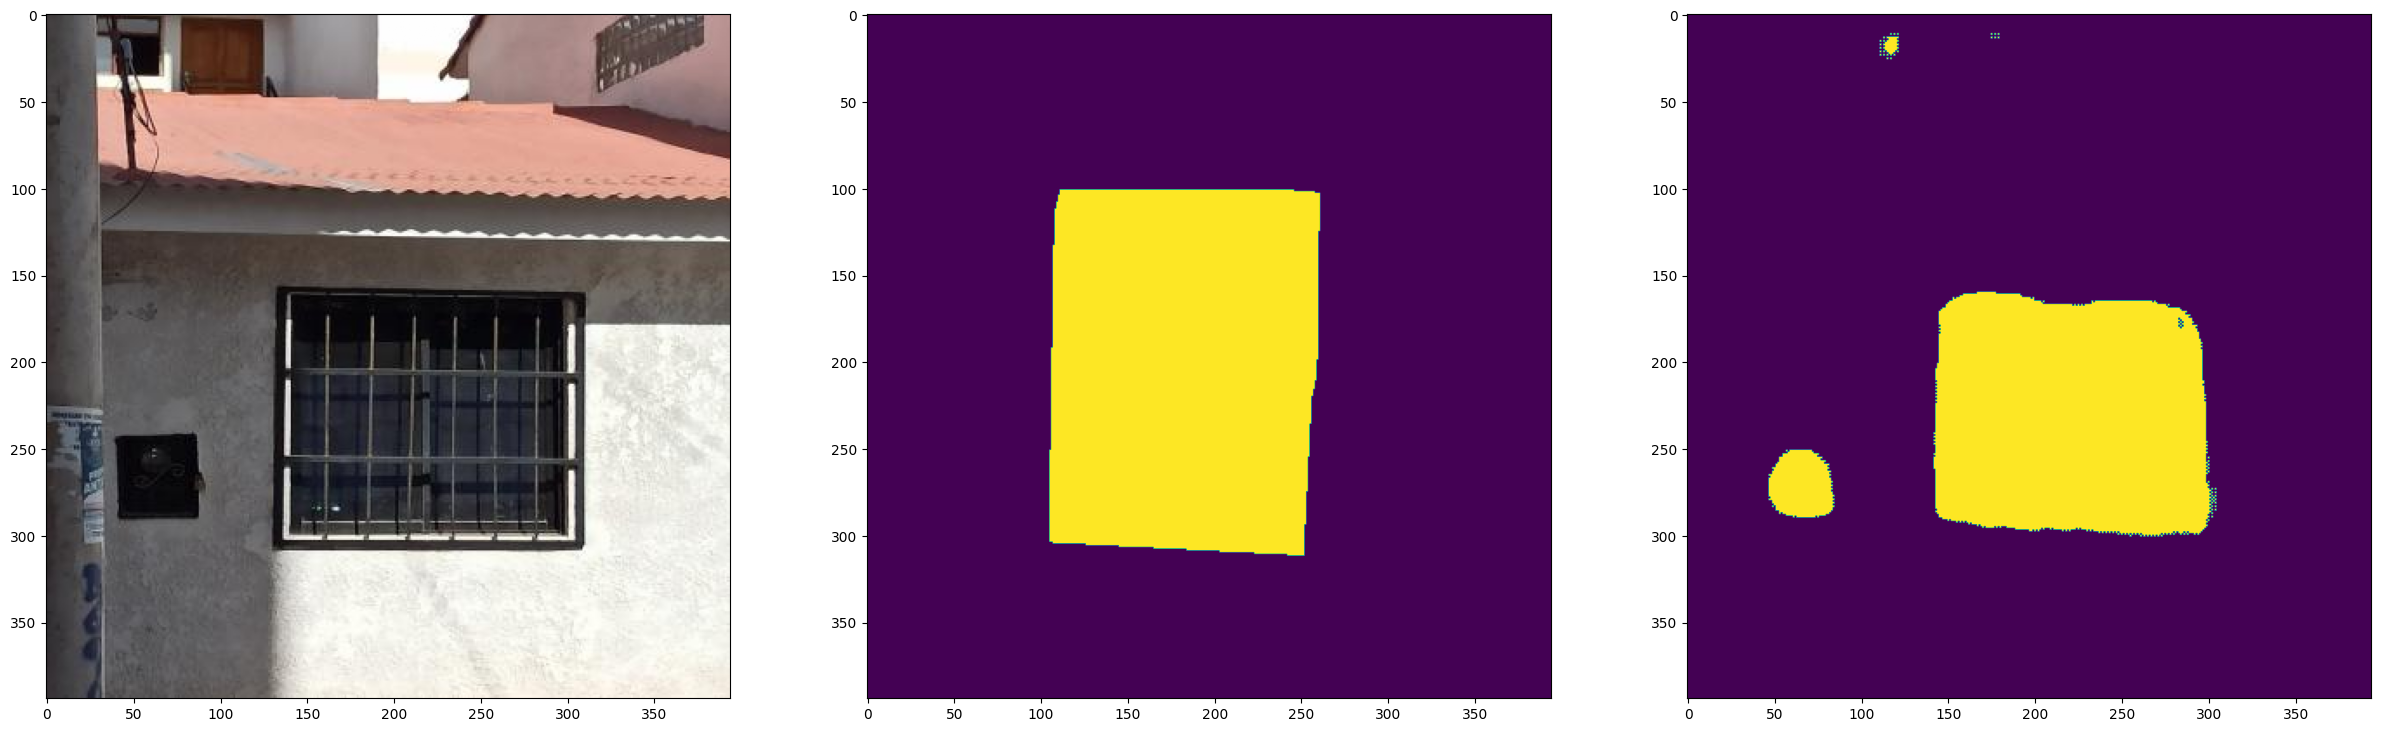

In [67]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
image = np.transpose(img.squeeze(0).numpy(), (1, 2, 0))
ax1.imshow(image)
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.